**Let's prepare the data:**

In [243]:
from pandas.plotting import register_matplotlib_converters
from scipy.stats import pearsonr 
from scipy.stats import linregress
from sklearn.metrics import adjusted_mutual_info_score, mutual_info_score,normalized_mutual_info_score
from pingouin import distance_corr,linear_regression
from math import ceil 

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize': (15, 8)})

In [5]:
inflation= pd.read_csv('data/inflation.csv', sep=",")
monetary_base= pd.read_csv('data/monetary_base.csv', sep=",", thousands='.')

In [6]:
inflation['Dates'] = pd.to_datetime(inflation['Dates'], format='%d/%m/%Y')    
inflation.index = inflation['Dates']
inflation = inflation.drop(['Dates'], axis=1)

In [7]:
monetary_base['Dates'] = pd.to_datetime(monetary_base['Dates'], format='%d/%m/%Y')    
monetary_base.index = monetary_base['Dates']
monetary_base = monetary_base.drop(['Dates'], axis=1)

[None]

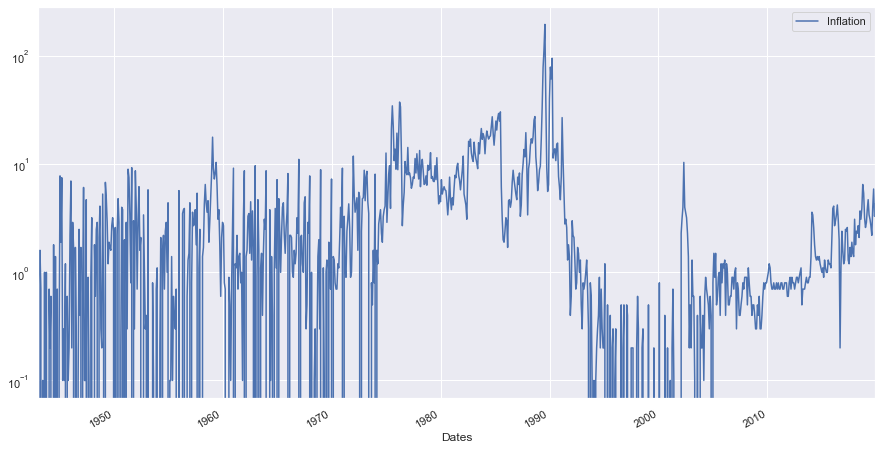

In [50]:
ax = inflation.plot()
ax.set(yscale="log")

[None]

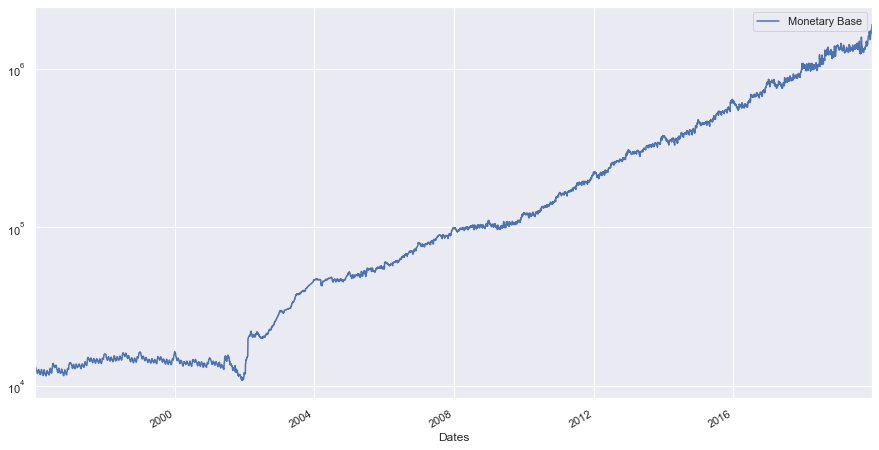

In [51]:
ax = monetary_base.plot()
ax.set(yscale="log")

In [105]:
inflation_1996 = {}
monetary_base_change_1996 = {}
data_1996 = {}
months = [1, 3, 6, 12]
for m in months:
    inflation_1996[m] = inflation.truncate(before = '1996-01-01')
    inflation_1996[m] = inflation_1996[m].apply(lambda x : x/100+1)
    inflation_1996[m] = inflation_1996[m].resample(str(m) + 'M').apply(lambda x : x.cumprod()[-1])
    inflation_1996[m] = inflation_1996[m].apply(lambda x : (x - 1) * 100)
    monetary_base_change_1996[m] = monetary_base.truncate(before='1996-01-01')
    monetary_base_change_1996[m] = monetary_base_change_1996[m].resample(str(m) + 'M').mean().pct_change()*100
    data_1996[m] = pd.DataFrame(monetary_base_change_1996[m])
    data_1996[m] = data_1996[m].assign(Inflation = inflation_1996[m]['Inflation']).dropna()

**Now let's calculate the pearson correlation:**

In [197]:
pearson_lagged = {}
for m in months:
    max_lag = 12*4//m
    correlation=[]
    for lag in np.arange(0, max_lag +1, 1):
        correlation.append(data_1996[m]['Inflation'].corr(data_1996[m]['Monetary Base'].shift(lag)))
    pearson_lagged[m]=correlation

In [199]:
to_plot = pd.DataFrame()
for m in months:
    to_plot=to_plot.append(pd.DataFrame([np.linspace(0,4,len(pearson_lagged[m])),pearson_lagged[m],[str(m)+ 'm']*len(pearson_lagged[m])]).T)
to_plot=to_plot.rename(columns={2:'months'})

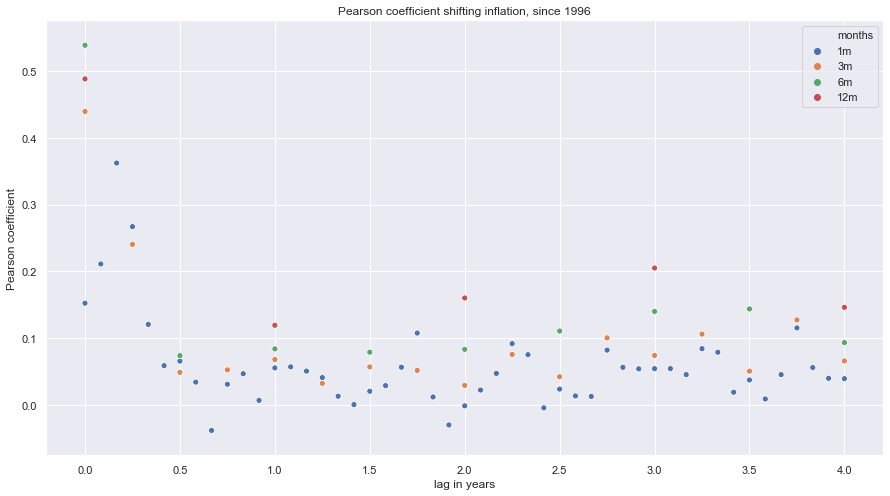

In [200]:
ax = sns.scatterplot(x= to_plot[0], y = to_plot[1], data = to_plot, hue = 'months')
ax.set(xlabel = 'lag in years', ylabel = 'Pearson coefficient', title = 'Pearson coefficient shifting inflation, since 1996')
ax

In [339]:
to_plot_heatmap = pd.DataFrame()

pearson_lagged[m]
for m in months:
    a=[ceil(m / 2)]+[m]*(48 // m-1) + [ceil(m / 2) + (m + 1)%2]
    to_plot_headmap = to_plot_headmap.append(pd.DataFrame([np.linspace(0, 4, 49), np.repeat(pearson_lagged[m], a),[m]*49]).T)
to_plot = to_plot_headmap.rename(columns = {0 : 'Lag in years', 2 : 'Months averaged'})

[]

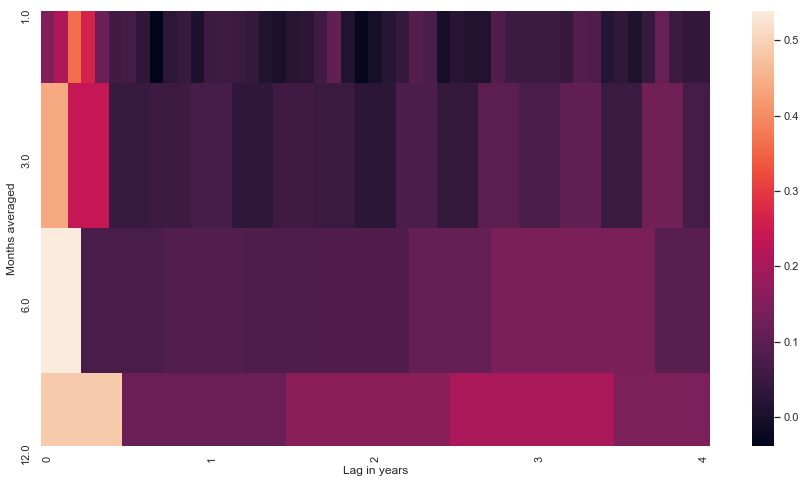

In [353]:
figure = to_plot.pivot("Months averaged", 'Lag in years', 1)
sns.heatmap(figure, fmt = "d")
plt.xticks(np.arange(49) + 0.5, ['0'] + [None]*11 + ['1']+ [None]*11 + ['2'] + [None]*11 + ['3'] + [None]*11 + ['4'])
plt.plot()